This is the notebook where I calculate the electronic populations of different types of electronic states using an analytical KMC hopping model. I specify a rate matrix that encapsulates the system of simulataneous differential equations due to site-to-site population transfer between CT and XT states. I then use this to calculate the time-dependent population of each site (or diabatic state).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import scipy.optimize as scopt

import sys
sys.path.insert(0, '/scratch/fivanovic/Work/X-SH/eigenstate_plotting')
sys.path.insert(0, '/scratch/fivanovic/X-SH/T6-PDI/production_runs/decay_fitting')
import XSH_eigenstates_Filip as XSF
import fitting_tools as FT

import transfer_rates as TR

/usr/lib64/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#setting the electronic structure up, site energies are just coulomb barrier or XT-CT offset terms, off-diagonals are RMS couplings obtained from 
#X-SH production runs

vecs = XSF.build_lattice(40,1,5)
dons, accs = XSF.DA_index(vecs, 20)
nearest_neighbours = XSF.build_connectivity(vecs, 5)

CT_states = XSF.define_CT_states_twophase(dons, accs)
XT_states = XSF.define_XT_states(accs)

H_CT = XSF.build_CT_block(CT_states, vecs, nearest_neighbours, -575, 90.7, 208.4, -1e-3) #field: -1e-3

H_XT = XSF.build_XT_block(XT_states, nearest_neighbours, 205.25, 87.3)
H_XT_CT = XSF.build_XT_CT_block(XT_states, CT_states, nearest_neighbours, 58.9)

#2 types of Hamiltonian here, one with 20 XT + iCT state, or 400 CT + 20 XT states

truncated_H = np.zeros((len(H_XT)+1, len(H_XT)+1))

truncated_H[:len(H_XT), :len(H_XT)] = H_XT
truncated_H[-1,-1] = H_CT[380,380]
truncated_H[-1,-2], truncated_H[-2,-1] = 66.9652, 66.9652

#rearraginng full H such that XT block comes first
number_diabats = len(H_XT) + len(H_CT)
H = np.zeros((number_diabats,number_diabats))
H[:len(H_XT), :len(H_XT)] = H_XT
H[len(H_XT):number_diabats, len(H_XT):number_diabats] = H_CT
H[len(H_XT)-1, 400], H[400, len(H_XT)-1] = 66.9652, 66.9652

In [3]:
number_excitons = len(H_XT)
number_CT_states = 400

#reorganisation energies, assume e/h-reorg energy are the same since they vary by 2 meV
reorg_xt = 390.5
reorg_xtct = 186.4
reorg_charge = 255.8

Ea_e5_adiab = []
Ea_warshel = []
ct_driving_forces = []

#effective nuclear freq
freq = 1539 #pentacene=1539 cm-1
rate_matrix = np.zeros((len(H), len(H)))

for j in range(len(H)):
    for k in range(len(H)):

        if j == k: continue

        deltaA = H[j,j] - H[k,k]
        V = H[j,k]**2

        if (j < number_excitons) and (k < number_excitons):
            reorgE = reorg_xt
        elif (j >= number_excitons) and (k >= number_excitons):
            reorgE = reorg_charge
        elif (j < number_excitons) or (k < number_excitons):
            reorgE = reorg_xtct

        rate_constant_w, deltaA_dagger_w = TR.marcus_sc_warshel(reorgE, deltaA, V, freq)
        rate_constant, deltaA_dagger = TR.marcus_sc(reorgE, deltaA, V, freq, -800, 800)

    #    if deltaA == -205.25:
    #        rate_constant = rate_constant_w
    #        print(rate_constant_w/1e12)
    #    elif deltaA == 205.25:
    #        rate_constant = rate_constant_w
    #        print(rate_constant_w/1e12)

        if (H[j,k] > 10) and (j > 19) and (k > 19):
            ct_driving_forces.append(deltaA)
            Ea_e5_adiab.append(deltaA_dagger)
            Ea_warshel.append(deltaA_dagger_w)

        rate_matrix[j,k] = rate_constant

for j in range(len(rate_matrix)):
    rate_column = rate_matrix[:,j]

    diagonal = np.sum(-rate_column)
    rate_matrix[j,j] = diagonal

rate_matrix = rate_matrix/1e12

In [81]:
avg_file = 'e5_2xCT'
physopt_iCT = np.loadtxt(f'/scratch/fivanovic/X-SH/T6-PDI/production_runs/saved_wf_processing/average_populations/{avg_file}_avg_INT.txt')
physopt_XT = np.loadtxt(f'/scratch/fivanovic/X-SH/T6-PDI/production_runs/saved_wf_processing/average_populations/{avg_file}_avg_XT.txt')
physopt_CT = np.loadtxt(f'/scratch/fivanovic/X-SH/T6-PDI/production_runs/saved_wf_processing/average_populations/{avg_file}_avg_CT.txt')
physopt_CSS = np.loadtxt(f'/scratch/fivanovic/X-SH/T6-PDI/production_runs/saved_wf_processing/average_populations/{avg_file}_avg_CSS.txt')

In [82]:
physopt_initial_diabats = np.loadtxt(f'/scratch/fivanovic/X-SH/T6-PDI/production_runs/saved_wf_processing/initial_diabat_pops/{avg_file}_avg_diabats_init.txt')
p_init = np.zeros((number_excitons+number_CT_states,1))

p_init[:number_excitons] = physopt_initial_diabats[-number_excitons:][:,np.newaxis]
p_init[number_excitons:] = physopt_initial_diabats[:-number_excitons][:,np.newaxis]

#p_init[-1] = np.sum(physopt_initial_diabats[:-number_excitons])

times = np.arange(0,10,0.01)
p_t = TR.time_dependent_populations(rate_matrix, times, p_init)

In [83]:
ct_distances = XSF.get_CT_distances(CT_states, vecs)
barrier_peak = 60

ct_distances = np.array(ct_distances[0])
css_indices = np.where(ct_distances > barrier_peak)[0] + number_excitons

hm_excitons = np.sum(p_t[:number_excitons],axis=0)
hm_ict = p_t[400]
hm_css = np.sum(p_t[css_indices],axis=0)
hm_ct = 1 - hm_ict - hm_excitons - hm_css

In [84]:
file_tag = 'e5_2xCT'

np.savetxt(f'populations/{file_tag}_hm_XT_population.txt', hm_excitons)
np.savetxt(f'populations/{file_tag}_hm_CT_population.txt', hm_ct)
np.savetxt(f'populations/{file_tag}_hm_CSS_population.txt', hm_css)
np.savetxt(f'populations/{file_tag}_hm_INT_population.txt', hm_ict)

In [85]:
biexp_guess = [3, 0.02, 10]
triexp_guess = [3, 0.4, 0.1, 2, 15]

triexp_fit = scopt.least_squares(FT.residual, triexp_guess, args = (times, hm_excitons, FT.triexp_exciton_decay), method='trf')
triexp_opt_parameters = triexp_fit.x

biexp_fit = scopt.least_squares(FT.residual, biexp_guess, args = (times, hm_excitons, FT.biexp_exciton_decay), method='trf')
biexp_opt_parameters = biexp_fit.x

In [86]:
def plot_lsq_fit(ax_object, fitting_path, population_path, simulation):

    population_array = np.loadtxt(population_path + f'/{simulation}_avg_XT.txt')
    initial_population = population_array[0]
    simulation_time = np.arange(len(population_array))*10*0.05/1000

    fit_parameters = np.loadtxt(fitting_path + f'/{simulation}-fit.txt')
    ax_object.plot(simulation_time, FT.biexp_exciton_decay(simulation_time, initial_population, fit_parameters[:4]), color = 'k', linewidth=1.5, label = 'X-SH Biexp Fit')

(0.0, 1.0)

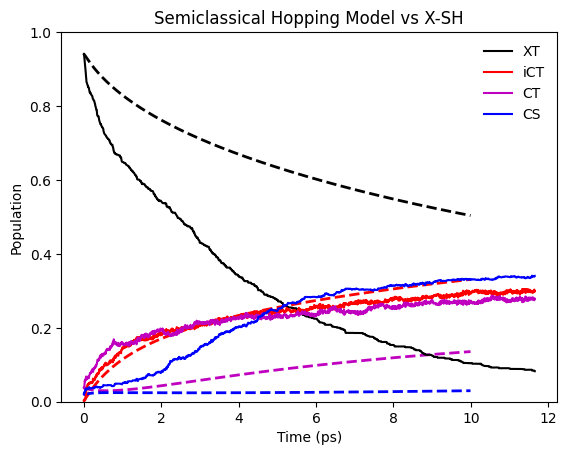

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(times, hm_excitons, color='k', linewidth=2, linestyle='--')
ax.plot(times, hm_ict, color='r', linewidth=2, linestyle='--')
ax.plot(times, hm_ct, color='m', linestyle='--', linewidth=2)
ax.plot(times, hm_css, color='b', linestyle='--', linewidth=2)

ax.plot(np.arange(len(physopt_XT))*0.05*10/1000, physopt_XT, color='k', linewidth=1.5, label='XT')
ax.plot(np.arange(len(physopt_iCT))*0.05*10/1000, physopt_iCT, color='r', linewidth=1.5, label='iCT')
ax.plot(np.arange(len(physopt_CT))*0.05*10/1000, physopt_CT, color='m', linewidth=1.5, label='CT')
ax.plot(np.arange(len(physopt_CSS))*0.05*10/1000, physopt_CSS, color='b', linewidth=1.5, label='CS')

#ax.plot(times, FT.triexp_exciton_decay(times, hm_excitons[0], triexp_opt_parameters), linewidth=1, color='orange', label='Tri-exp Hopping Fit')
#ax.plot(times, FT.biexp_exciton_decay(times, hm_excitons[0], biexp_opt_parameters), linewidth=1, color='c', label='Bi-exp Hopping Fit')
#plot_lsq_fit(ax, '../production_runs/decay_fitting/biexp_fits', '../production_runs/saved_wf_processing/average_populations', 'e3.5_2xCT')
ax.set_title('Semiclassical Hopping Model vs X-SH')
ax.set_ylabel('Population')
ax.set_xlabel('Time (ps)')
ax.legend(frameon=False)
ax.set_ylim([0,1])

In [88]:
print('biexp coeffs:', FT.get_biexp_coeffs(biexp_opt_parameters[2], np.sum(p_t[:-1,0],axis=0)))
print('triexp coeffs:', FT.get_triexp_coeffs(triexp_opt_parameters[3], triexp_opt_parameters[4], np.sum(p_t[:-1,0],axis=0)))

biexp coeffs: (0.15646161309268752, 0.8434744047514036)
triexp coeffs: (0.05269608522260743, 0.17693540094972982, 0.7703045316717538)


In [89]:
print('biexp rates:', biexp_opt_parameters[:-1])
print('triexp rates:', triexp_opt_parameters[:3])

biexp rates: [0.6938454  0.04619815]
triexp rates: [1.5845736  0.31864013 0.03786395]


In [90]:
ssq = np.sum((hm_excitons - FT.triexp_exciton_decay(times, np.sum(p_t[:number_excitons,0]), triexp_opt_parameters))**2)
tss = np.sum(hm_excitons**2)

r2 = 1 - ssq/tss
print(r2)

number_features = 6
adjusted_r2 = 1 - (1-r2)*(len(hm_excitons)-1)/(len(hm_excitons) - number_features - 1)
print(adjusted_r2)

0.9999999559572906
0.9999999556911715


Plotting the adiabatic/diabatic free energies of different CT pairs, to see which regime they are in (normal or inverted Marcus), and if they have any activation barrier or not.

Physical system:

iCT - CT (e-e) - inverted with barrier: take energy differences between TS(deltaE=0) and PES minima
iCT - CT (h-h) - inverted with barrier: TS-minima energy difference
CT - CT (e-e) - no barrier: activation E = 0 or driving force depending on direction
CT - CT (h-h) - no barrier: activation E = 0 or driving force depending on direction

0.0
331.0552804430591
321.05583278258035


Text(0.5, 0, 'Energy gap (meV)')

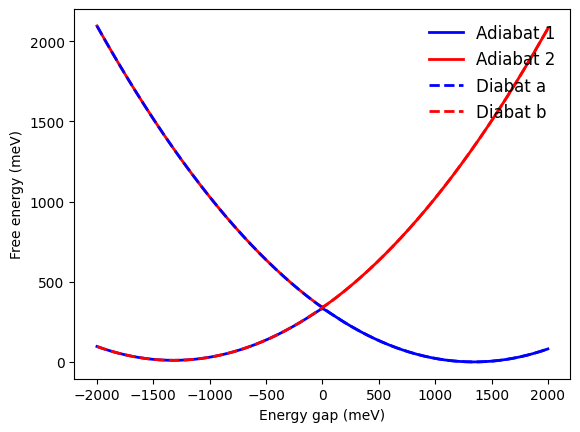

In [26]:
deltaE = np.arange(-2000,2000)
deltaA = 10
V = 7**2
reorg = 4*333

Aa = ((deltaE - (deltaA + reorg))**2)/(4*reorg)
Ab = ((deltaE - (deltaA - reorg))**2)/(4*reorg) + deltaA

A0 = 0.5*(Aa + Ab) - 0.5*np.sqrt(deltaE**2 + 4*V)
A1 = 0.5*(Aa + Ab) + 0.5*np.sqrt(deltaE**2 + 4*V)

ts_index = np.where(deltaE == 0)[0][0]
print(A1[ts_index] - np.min(A1))
print(A0[ts_index] - np.min(A0[ts_index+1:]))
print(A0[ts_index] - np.min(A0[:ts_index+1]))

plt.plot(deltaE, A0, color='b', linewidth=2, label='Adiabat 1')
plt.plot(deltaE, A1, color='r', linewidth=2, label='Adiabat 2')
plt.plot(deltaE, Aa, color='b', linewidth=2, linestyle='--', label='Diabat a')
plt.plot(deltaE, Ab, color='r', linewidth=2, linestyle='--', label='Diabat b')
plt.legend(loc='upper right', fontsize=12, frameon=False)
plt.ylabel('Free energy (meV)')
plt.xlabel('Energy gap (meV)')
#plt.text(-350, 2000, f'\u0394A$_{0}$ = {deltaA} meV')
#plt.text(-350, 1850, f'\u03BB = {reorg} meV')
#plt.text(-350, 1700, f'V = {np.sqrt(V)} meV')

In [32]:
rate, Ea = TR.marcus_sc(reorg, deltaA, V, freq, -2000, 2000)
print(rate/1e6)

1.9182940365943242


In [34]:
rate = TR.marcus_na(reorg, deltaA, V)
print(rate/1e6)

1.4820727876690853
